## Air Quality in Vanderbijlpark Prediction (ARIMA)

In [1]:
import warnings
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings(action='ignore')
import time

In [2]:

def wrangle(filename):
    #We read the filename into a dataframe and passing the ';' as a delimiter
    df = pd.read_csv(filename,delimiter=';')
    # We convert our timestamp column of object datatype to a timestamp datatype
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # We set the index of the dataframe to be the timestamp 
    df.set_index('timestamp',inplace=True)
    #We  convert the timestamp to the 'Africa/Johannesburg' timezone since the dataset is gotten from Vanderbijlpark
    df.index = df.index.tz_convert('Africa/Johannesburg')
    #Sort Our data Frame by index
    df = df.sort_index()
    #We mask our DataFrame to return value that contains the P2 value type
    mask = df['value_type'] == 'P2'
    df  = df[mask]
    ## we identify column with low and high cardinality and drop them
    low_cardinality_list = [column for column in df.columns if df[column].nunique() < 2 ]
    df.drop(low_cardinality_list,axis=1,inplace = True)
    # We resample the dataframe to return a series with the mean of the P2 value for every Hour
    y =  df['value'].resample('1H').mean().fillna(method ='ffill')
    y.name = 'P2'
    return y
    

### 1. IMPORT

In [3]:
#Returns all files that matches the pattern as specified in the glob function argument
files = glob('data/*_2021_sensor_data_archive.csv')

In [4]:
#A list comprehension for that perform the wrangle function for each file in the list created by glob funtion
list_of_df = [wrangle(file) for file in files]
# We concatenate the list of dataframes into one dataframe using the pd.concat method and set index to the timestamp
y = pd.concat(list_of_df).sort_index()

### 2. EXPLORE

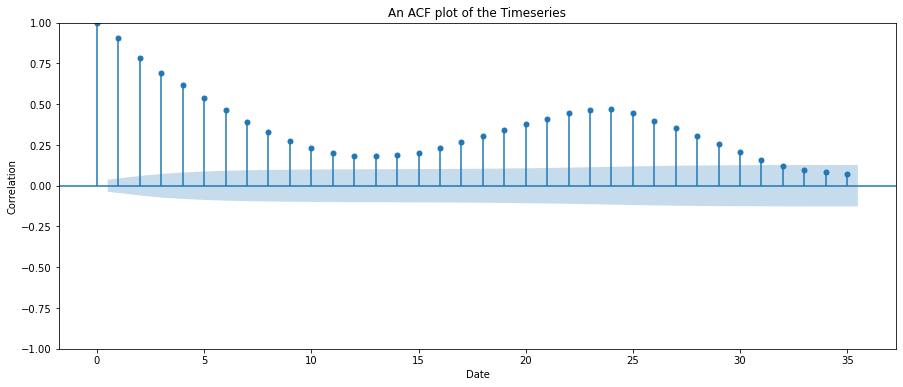

In [5]:
# An ACF plot for the correlation of the series for each lags
fig,ax = plt.subplots(figsize=(15,6))
plot_acf(y,ax=ax)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('An ACF plot of the Timeseries');

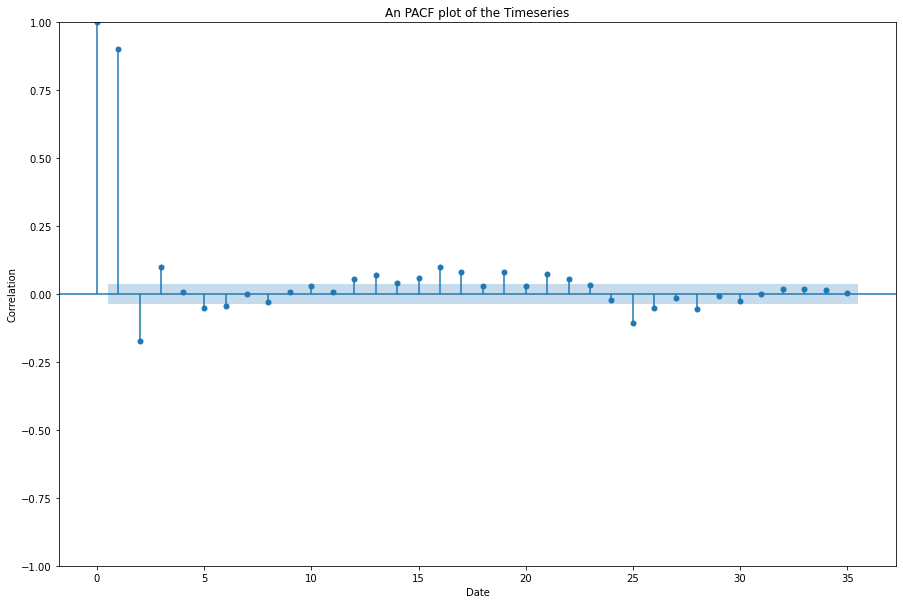

In [6]:
# An PACF plot for the correlation of the series for each lags
fig,ax = plt.subplots(figsize=(15,10))
plot_pacf(y,ax=ax)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('An PACF plot of the Timeseries');

### 3. SPLIT

In [7]:
#We split our y data into train and test set with less data size for both test and train set  due to ARMA model being computationally expensive
y_train = y['2021-09-01 00:00:00+02:00':'2021-09-30 23:00:00+02:00']
y_test = y['2021-10-01 00:00:00+02:00':'2021-10-01 23:00:00+02:00']

### 4. BUILD MODEL

In [8]:
#### A. BASELINE

In [9]:
# We create a baseline model which would be used to test how well our test data those.
# The baseline will be the mean absolute error of y_train against that of y_mean
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
y_baseline_df = pd.DataFrame({'y_train' : y_train,'y_baseline':y_pred_baseline})
mae = mean_absolute_error(y_train,y_pred_baseline)
print(f' The mean of the y_train is {y_mean}')
print(f' The mean absolute error of the baseline model is {mae}')

 The mean of the y_train is 37.28107772728039
 The mean absolute error of the baseline model is 12.484687161904352


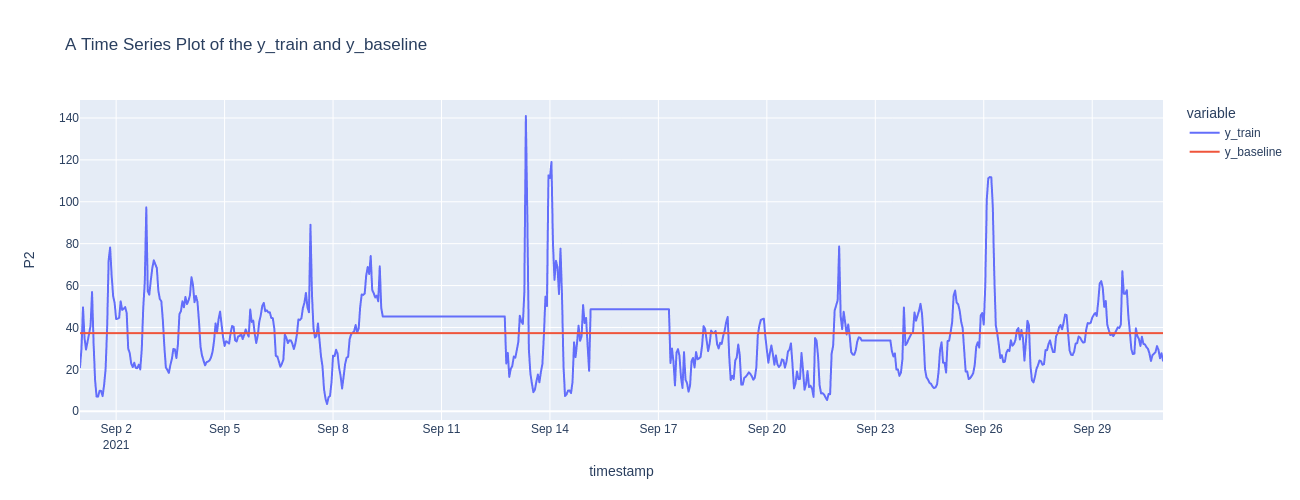

In [10]:
fig = px.line(y_baseline_df,labels={'value':'P2'},title='A Time Series Plot of the y_train and y_baseline',width=1300)
fig.show('png');

#### B. AUTO REGRESSION MODEL

In [11]:
# We instantiate our Auto regression model and set the lags to the max number of lag that produced a good correlation in pacf plot
hyperparameter_p = range(0,26,8)
hyperparameter_q = range(0,3)
mae_dict = {}
for p in hyperparameter_p:
    mae_dict[p] = []
    for q in hyperparameter_q:
        order = (p,0,q)
        start_time = time.time()
        model = ARIMA(y_train,order=order).fit()
        y_pred = model.predict()
        mae = mean_absolute_error(y_train,y_pred)
        mae_dict[p].append(mae)
        elapsed_time = round((time.time()-start_time),2)
        print(order,elapsed_time)
        
#auto_reg_model = AutoReg(y_train,lags=lags).fit()

(0, 0, 0) 0.28
(0, 0, 1) 0.24
(0, 0, 2) 0.42
(8, 0, 0) 2.44
(8, 0, 1) 2.69
(8, 0, 2) 2.44
(16, 0, 0) 23.57
(16, 0, 1) 14.17
(16, 0, 2) 15.01
(24, 0, 0) 109.21
(24, 0, 1) 133.63
(24, 0, 2) 120.36


In [12]:
df_mae = pd.DataFrame(mae_dict)

In [13]:
df_mae

,0,8,16,24
0,12.484687,5.037943,5.025379,4.992003
1,8.030568,5.060428,5.023115,4.988497
2,6.718020,5.054261,5.024533,4.975856


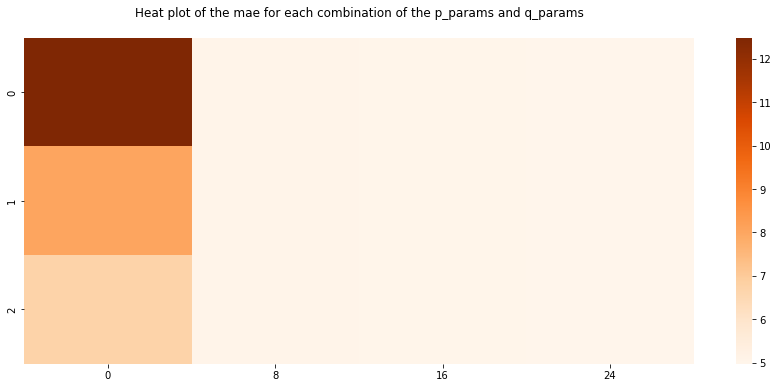

In [14]:
fig,ax = plt.subplots(figsize=(15,6))
plt.title('Heat plot of the mae for each combination of the p_params and q_params\n')
sns.heatmap(df_mae,cmap='Oranges',ax=ax);

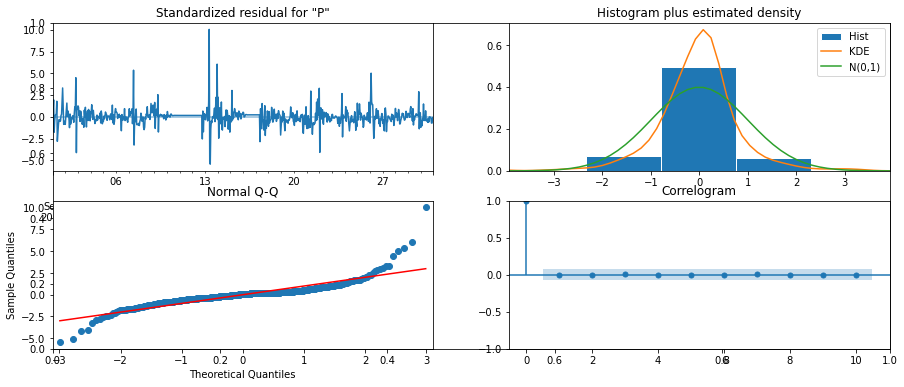

In [15]:
#We plot the residual for the model we built
fig,ax = plt.subplots(figsize=(15,6))
model.plot_diagnostics(fig=fig);

In [16]:
# Next we perform a walk forward validation for the entire test set. We create a function
def walk_forward_validation(y_train,y_test):
    order = (8,0,0)
    y_pred_wfv = pd.Series()
    history = y_train.copy()
    for i in range(len(y_test)):
        model = ARIMA(history,order =order).fit()#lags  is 26
        next_pred = model.forecast()
        y_pred_wfv = y_pred_wfv.append(next_pred)
        history = history.append(y_test[next_pred.index])
    return y_pred_wfv,model

In [17]:
y_pred_wfv,model = walk_forward_validation(y_train,y_test)

In [18]:
# We generate the prediction of the test set and check for the mean absolute error.
ARIMA_model_test_mae = mean_absolute_error(y_test,y_pred_wfv)
print(f' The mean absolute error of the Auto Regression model with the test set is {ARIMA_model_test_mae}')

 The mean absolute error of the Auto Regression model with the test set is 3.8912318707296976


### 5. COMMUNICATE RESULTS

In [19]:
#Next we print out the coefficient of the model used
def print_model_equation(model):
    model_dict = dict(model.params)
    equation = ''
    equation = equation + f"{model_dict['const']}"
    for key,value in model_dict.items():
        if key != 'const' and value > 0:
            equation = equation + f' + {value}*{key}'
        elif key != 'const' and value < 0:
            equation = equation + f' {value}*{key}'
    return equation

In [20]:
print_model_equation(model)

'37.12768326524753 + 0.9748046603049304*ar.L1 -0.17229542093832245*ar.L2 + 0.07438907602938305*ar.L3 -0.03766188808617333*ar.L4 -0.004335062479673388*ar.L5 -0.00966735607406751*ar.L6 + 0.010279268585123319*ar.L7 -0.05248814695014469*ar.L8 + 72.57473436138795*sigma2'

In [21]:
# We create a DataFrame for the predicted test set and the True test set
y_test_pred_df = pd.DataFrame({
    'y_test':y_test,
    'y_pred_wfv':y_pred_wfv
})
y_test_pred_df.head()

,y_test,y_pred_wfv
2021-10-01 00:00:00+02:00,32.409074,26.025688
2021-10-01 01:00:00+02:00,38.650727,35.073167
2021-10-01 02:00:00+02:00,34.697778,39.408533
2021-10-01 03:00:00+02:00,41.450556,35.031516
2021-10-01 04:00:00+02:00,32.608519,42.540719


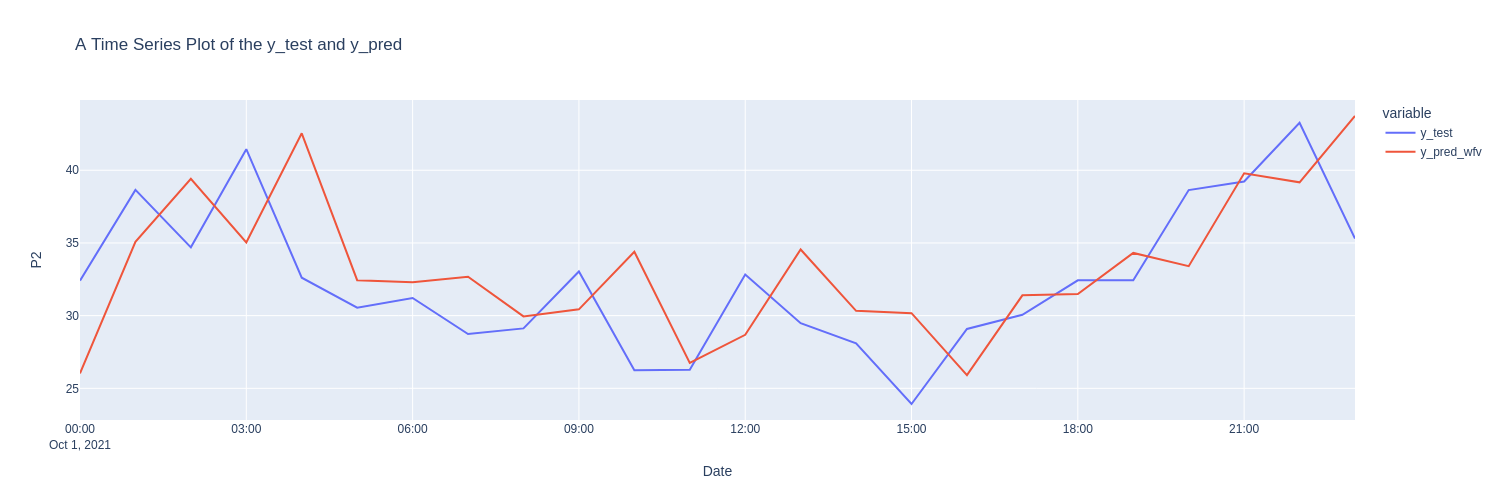

In [22]:
fig = px.line(y_test_pred_df,labels={'value':'P2','index':'Date'},title='A Time Series Plot of the y_test and y_pred',width=1500)
fig.show('png');